# Импорт библиотек

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Датасет

In [28]:
df = pd.read_csv("Titanic.csv")

In [29]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Сделаем первичный анализ данных

Задача - предсказать выживаемость пассажиров Титаника, поэтому самый нужный для нас параметр - Survived

Уже сейчас замечаем пропуски в полях, например в поле Age и Cabin. Посмотрим, что можно будет с этим сделать дальше

# Анализ данных и построение графиков

Посмотрим на плотность распределения возраста по классам

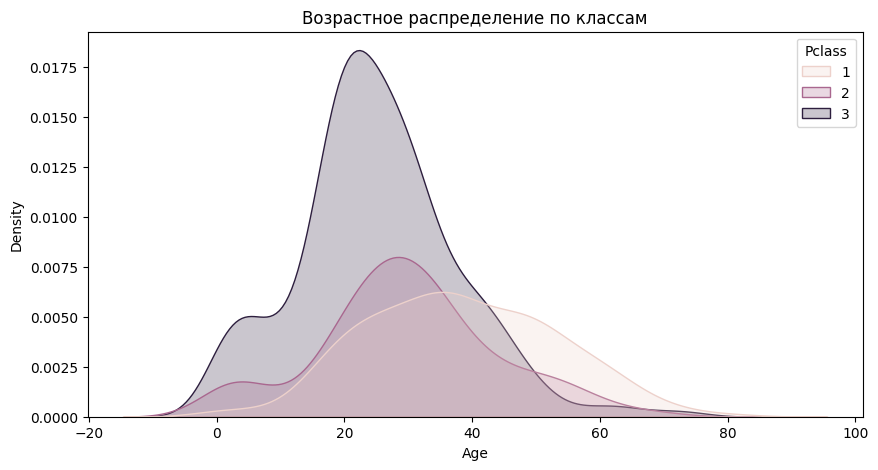

In [30]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x="Age", hue="Pclass", fill=True)
plt.title("Возрастное распределение по классам")
plt.show()

*Видно, что пассажиры 1-го класса в среднем старше по возрасту, чем пассажиры 2-го класса. Это может говорить о том, что в первом классе находились пассажиры с более высокими доходами, что потенциально влияет на шансы выживания*

Теперь проанализируем взаимосвязь между кол-вом родственников и выживаемостью

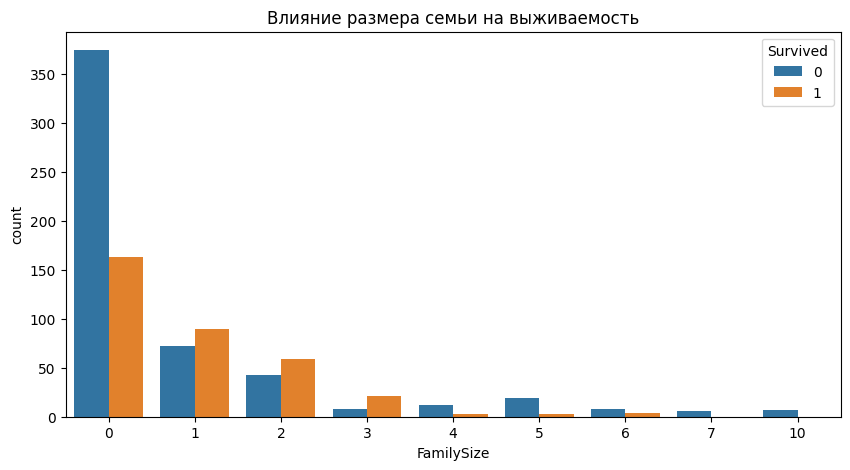

In [31]:
df['FamilySize'] = df['SibSp'] + df['Parch']
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="FamilySize", hue="Survived")
plt.title("Влияние размера семьи на выживаемость")
plt.show()

*Видно, что пассажиры с небольшим кол-вом родственников имеют большие шансы на выживание, тогда как одинокие пассажиры и пассажиры с большими семьями выживают реже*

Посмотрим влияние порта отправления на выживаемость

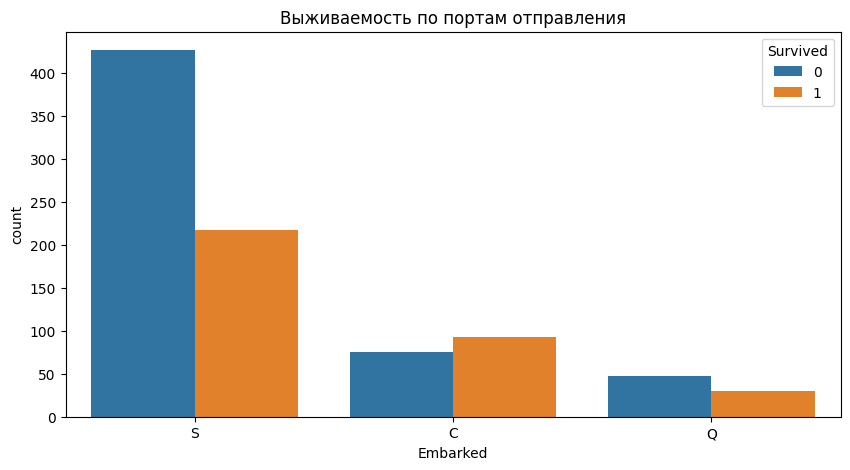

In [32]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="Embarked", hue="Survived")
plt.title("Выживаемость по портам отправления")
plt.show()

*Видно, что пассажиры, севшие на борту C имеют более высокие шансы на выживание, по сравнению с людьми, севшими в других портах.*

Посмотрим на взаимосвязь между классами и выживаемостью

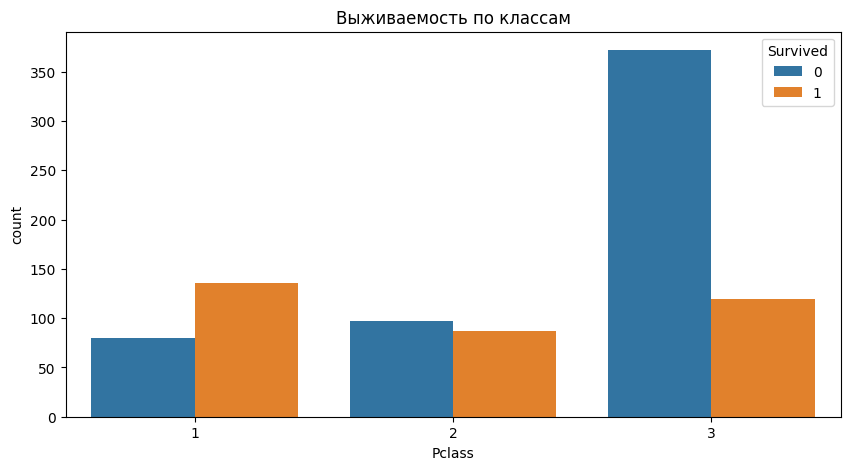

In [33]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="Pclass", hue="Survived")
plt.title("Выживаемость по классам")
plt.show()

*Видно, что пассажиры первого класса имели значитально более высокие шансы на выживание, чем пассажиры второго и особенно третьего классов. Это, в принципе, объясняется тем, что у первого класса есть привелегии: доступ к спасательным средствам и так далее, что помогает выжить*

# Feature Engineering

Создадим новые признаки

Создадим признак AgeGroup, который будет помогать различать выживаемость в зависимости от возрастных категорий (дети, подростки, взрослые, пожилые). Это может помочь в лучшей классификации возрастных групп, которые проявляют разные уровни выживаемости

In [34]:
# Создаем признак AgeGroup
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 50, 80], labels=['Child', 'Teen', 'Adult', 'Senior'])

отобразим этот признак на графике

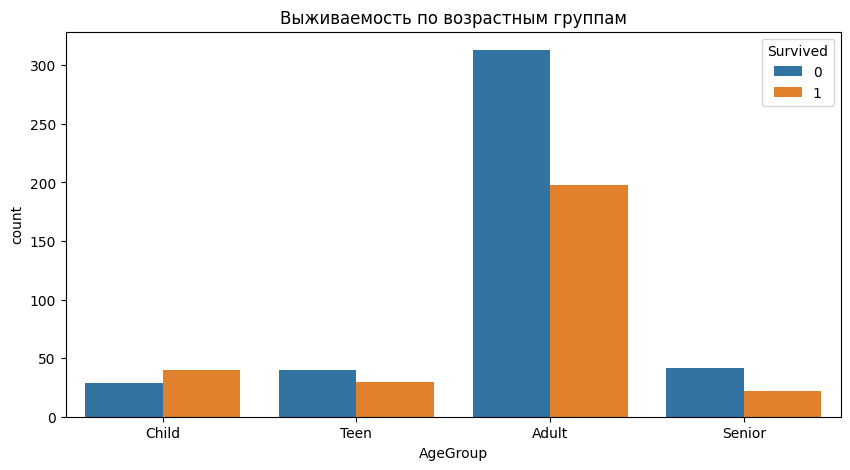

In [35]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="AgeGroup", hue="Survived")
plt.title("Выживаемость по возрастным группам")
plt.show()

*График показывает, что дети имели высокий шанс выжить, тогда как пожилые люди выживали реже. Это связно с приоритетом детей на спасение и само собой, меньшей способностью пожилых людей эвакуироваться*

Создадим признак FamilySize. Он может быть полезен, так как показывает количество родственников пассажира, путешествующих с ним. Люди, путешествующие с семьёй, могли бы иметь повышенные шансы на выживание, так как могли помогать друг другу во время эвакуации. FamilySizeобъединит количество родственников, указанных в признаках SibSp (братья, сёстры, супруги) и Parch (родители, дети), добавив 1 (чтобы учесть самого пассажира).

In [36]:
# Создаем признака FamilySize
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1 # +1, т.к. учитываем самого пассажира

отобразим этот признак на графике

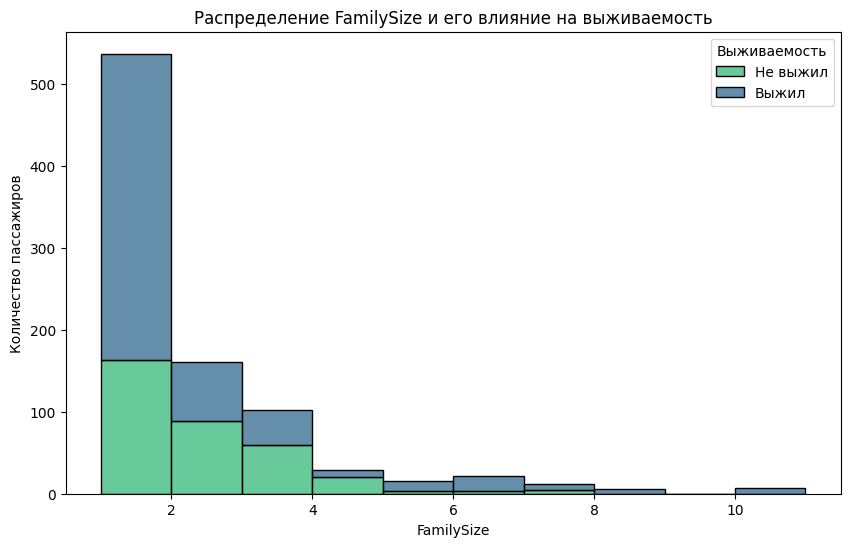

In [37]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='FamilySize', hue='Survived', multiple="stack", kde=False, palette="viridis", binwidth=1)
plt.title("Распределение FamilySize и его влияние на выживаемость")
plt.xlabel("FamilySize")
plt.ylabel("Количество пассажиров")
plt.legend(title='Выживаемость', labels=['Не выжил', 'Выжил'])
plt.show()

*График показывает, что пассажиры с небольшим размером семьи имели более высокие шансы на выживаемость, тогда как пассажиры с очень большим числом родственников или те, кто путешествовал один, имели пониженную вероятность выжить*

Добавим признак Title - звание из имени пассажира. Это может быть индикатором возраста и социального статуса, что в теории может оказывать влияние на выживаемость. Т.к. Mrs - замужняя женщина, значит есть семья, а значит есть вероятность, что шансы на выживание будут выше

In [38]:
df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

Посмотрим как влияет звание пассажира не его выживаемость

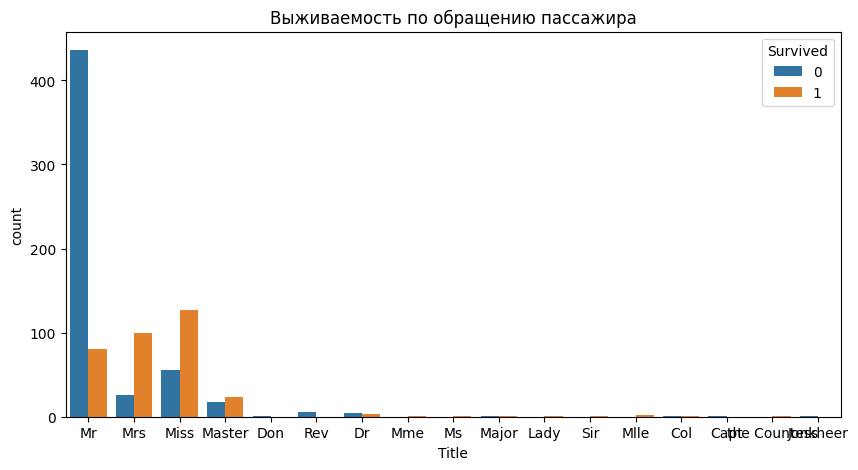

In [39]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="Title", hue="Survived")
plt.title("Выживаемость по обращению пассажира")
plt.show()

*По графику видно, что высокие статусы - Mrs и Miss имеют более высокие показатели выживаемости по сравнению с более низкими статусами.*

# Предобработка и подготовка данных

Посмотрим на наличие пропусков в полях

In [40]:
print(df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
FamilySize       0
AgeGroup       177
Title            0
dtype: int64


Видим, что есть 177 пропусков в поле Age, 687 пропусков в поле Cabin и 2 пропуска в поле Embarked.

In [41]:
df['Age'].fillna(df['Age'].median(), inplace=True) # заполним медианным значением

df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True) # всего 2 значения, можно заполнить модой

print(df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
FamilySize       0
AgeGroup       177
Title            0
dtype: int64


<ipython-input-41-c69ecd112032>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True) # заполним медианным значением
<ipython-input-41-c69ecd112032>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].metho

Поле Cabin можно удалить, т.к. оно содержит слишком много пустых значений

In [42]:
df = df.drop(columns=['Cabin']) # удаляем поле Cabin

print(df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
FamilySize       0
AgeGroup       177
Title            0
dtype: int64


Также есть поля Name, PassengerId и Ticket, которые никак не влияют на выживаемость, поэтому удалим их

In [43]:
df = df.drop(columns=['Name', 'PassengerId', 'Ticket']) # Удаляем поля Name, PassengerId и Ticket

print(df.isnull().sum())

Survived        0
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Embarked        0
FamilySize      0
AgeGroup      177
Title           0
dtype: int64


Теперь можно обработать данные и разделить их на обучающую и тестовую выборки

In [45]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Преобразуем AgeGroup в числовой формат, используя LabelEncoder
label_encoder = LabelEncoder()
df['AgeGroup'] = label_encoder.fit_transform(df['AgeGroup'])
df['Title'] = label_encoder.fit_transform(df['Title'])

X = df[['AgeGroup', 'FamilySize', 'Title']]
y = df['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучений модели

Используем 32 и 16 нейронов в двух скрытых слоях с активацией relu

Также добавим Dropout для контроля переобучения

In [46]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Компиляция модели
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Обучение модели
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val))

y_pred = (model.predict(X_val) > 0.5).astype("int32")

print("Classification Report:")
print(classification_report(y_val, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# Вывод точности на валидационном наборе
val_accuracy = history.history['val_accuracy'][-1]
print(f"Точность на валидационном наборе: {val_accuracy:.4f}")

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5120 - loss: 0.9682 - val_accuracy: 0.5866 - val_loss: 0.8100
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4944 - loss: 0.8564 - val_accuracy: 0.5866 - val_loss: 0.7359
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5842 - loss: 0.7108 - val_accuracy: 0.5866 - val_loss: 0.6928
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5526 - loss: 0.7128 - val_accuracy: 0.5866 - val_loss: 0.6900
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5763 - loss: 0.6903 - val_accuracy: 0.5866 - val_loss: 0.6729
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5918 - loss: 0.6764 - val_accuracy: 0.5866 - val_loss: 0.6691
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5442 - loss: 0.6971 - val_accuracy: 0.5866 - val_loss: 0.6644
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6466 - loss: 0.6438 - val_accuracy: 0.5866 - val_loss: 0.

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.71      0.75       105
           1       0.64      0.73      0.68        74

    accuracy                           0.72       179
   macro avg       0.72      0.72      0.72       179
weighted avg       0.73      0.72      0.72       179

Confusion Matrix:
[[75 30]
 [20 54]]
Точность на валидационном наборе: 0.7207


Чтобы построить график и сделать выводы по результатам обучения модели на основе признаков AgeGroup и FamilySize, отобразим точность (accuracy) и потерю (loss) на обучающем и валидационном наборах в процессе обучения.

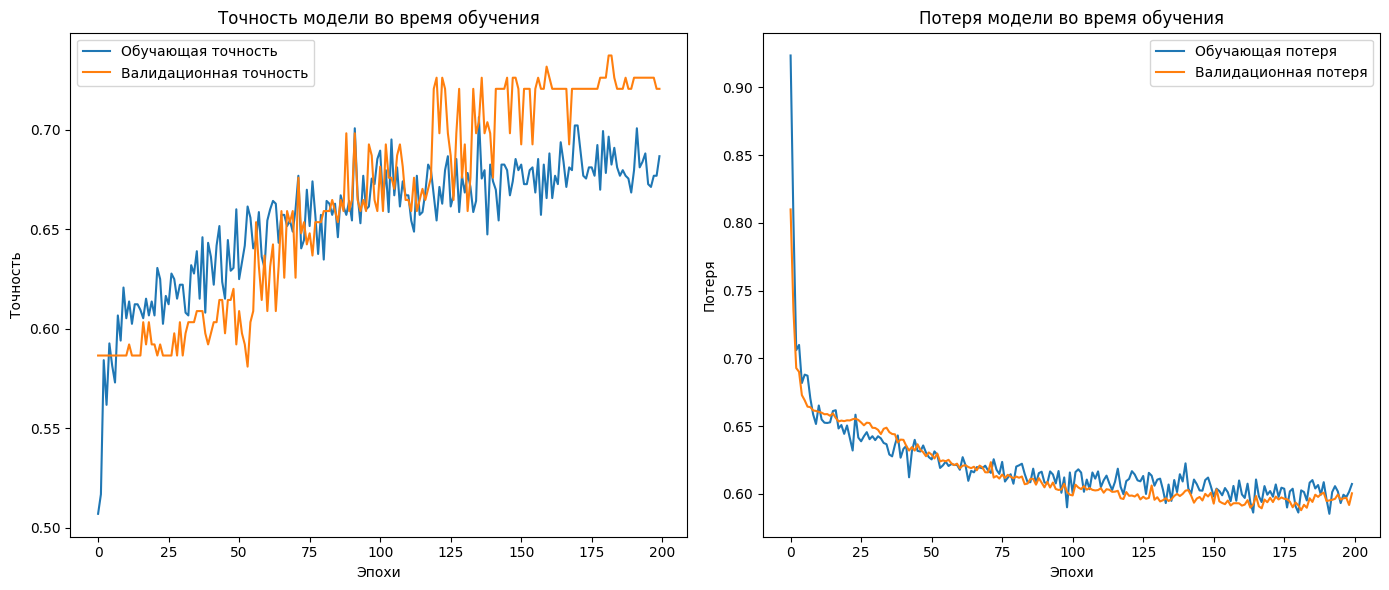

In [47]:
import matplotlib.pyplot as plt

# График точности
plt.figure(figsize=(14, 6))

# Подграфик для точности
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Обучающая точность')
plt.plot(history.history['val_accuracy'], label='Валидационная точность')
plt.title('Точность модели во время обучения')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()

# Подграфик для потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Обучающая потеря')
plt.plot(history.history['val_loss'], label='Валидационная потеря')
plt.title('Потеря модели во время обучения')
plt.xlabel('Эпохи')
plt.ylabel('Потеря')
plt.legend()

plt.tight_layout()
plt.show()

# Вывод

Я получила точность модели 0.7207, что в принципе неплохо, но и также является отправной точкой для дальнейших улучшений. Возможно, стоит провести дополнительные эксперименты с выбором признаков, настройкой архитектуры сети и использованием методов кросс-валидации для оценки модели более надежно.